# A Bayesian Approach to Quadrature (Numerical Integration)
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\Ybar}{\overline{Y}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
\newcommand{\GP}{\mathrm{GP}}
\newcommand{\vf}{\boldsymbol{f}}
\newcommand{\vk}{\boldsymbol{k}}
\newcommand{\vy}{\boldsymbol{y}}
\newcommand{\mK}{\mathsf{K}}
$$
The __trapezoidal rule__ is used to approximate integrals when one cannot do so analytically.  One may derive this rule via a Bayesian statistical approach.

We assume that the integrand, $f$, is a random function, in particular an instance of a Gaussian stochastic process, i.e., $f \sim \GP(0, K)$.  Here the mean of $f$ is assumed to be the zero function, and $K$ describes how much values of the function vary from place to place:

- $\Ex[f(x)] =  0$ 

- $\Ex\bigl[f(t)f(x) \bigr] = K(t,x)$ for some specified covariance kernel, $K$

- What is the **population**?  All continuous functions
- Why are we **sampling**?  Because the function is too complex to integrate by hand
- Why do we think that we can know what they think?  If we do the sampling carefully, we only need about $1500$ or so responses to have a good idea.

In [1]:
%run ~/Documents/SharedConfigs/python/dev_check.py

Python: /Users/fredjhickernell/miniconda3/envs/qmcpy-dev/bin/python
classlib from: /Users/fredjhickernell/SoftwareRepositories/HickernellClassLib/classlib/__init__.py
qmcpy from: /Users/fredjhickernell/SoftwareRepositories/QMCSoftware/qmcpy/__init__.py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import classlib as cl

%matplotlib inline

rng = np.random.default_rng(20251222)

cl.nbviz.init(use_tex=True)
cl.nbviz.configure(figpath="figures/bayesian_cubature", savefigs=True, imgfrmt="png")
colors = cl.nbviz.TOL_BRIGHT

## Bayesian Posterior Function Approximation

The Bayesian posterior mean of the $f(x)$ for an arbitrary $x$ conditioned on the data 
$$
\vf :=  \begin{pmatrix} 
f(x_1) \\
\vdots \\
f(x_n)
\end{pmatrix}
= 
\begin{pmatrix} 
y_1 \\
\vdots \\
y_n
\end{pmatrix} =: \vy
$$
is given by 
$$
\Ex\bigl[f(x) \mid \vf  = \vy\bigr] = \vy^\top \mK^{-1} \vk(x) , \qquad 
\text{where } \vk(x) = \bigl( K(x,x_i) \bigr)_{i=1}^n, \quad \bigl(K(x_i,x_j)\bigr)_{i,j=1}^n =: \mK
$$

We show some plots for the special case $K(t,x) = 2 - \lvert t - x \rvert$

### Functions to work with kernels

Here is a our kernel and some functions to return the Gram matrix and the kernel vector

In [3]:
def K_abs(t, x):
    # Vectorized covariance kernel: works for scalars or numpy arrays via broadcasting
    return 2.0 - np.abs(np.asarray(t) - np.asarray(x))
K_abs.label = r"$K(t,x)=2-\lvert t-x|$"

def kernel_tools(K, x, *, return_gram=True, return_kfun=True, dtype=float):
    """
    Given a kernel K(t,x) and nodes x = (x1,...,xn), return:
      - Gram matrix G[i,j] = K(xi, xj)  (optional)
      - a function k(t) = [K(t,x1),...,K(t,xn)] (optional)

    Parameters
    ----------
    K : callable
        Vectorized kernel supporting broadcasting, e.g.
        K(X[:,None], X[None,:]) -> (n,n) and K(t, X) -> (n,)
    x : array-like, shape (n,)
        Nodes x1,...,xn
    return_gram : bool
    return_kfun : bool
    dtype : type
        dtype for outputs

    Returns
    -------
    G and/or k depending on flags.
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    out = []

    if return_gram:
        G = np.asarray(K(x[:, None], x[None, :]), dtype=dtype)
        out.append(G)

    if return_kfun:
        def k(t):
            return np.asarray(K(np.asarray(t), x), dtype=dtype).reshape(-1)
        out.append(k)

    return out[0] if len(out) == 1 else tuple(out)

def kernel_interpolant(K, x_nodes, f):
    x_nodes = np.asarray(x_nodes, dtype=float).reshape(-1)

    G, k = kernel_tools(K, x_nodes)   # <-- use your kernel_tools
    y = f(x_nodes)
    a = np.linalg.solve(G, y)

    def f_hat(x):
        x = np.asarray(x, dtype=float)
        Phi = K(x[..., None], x_nodes[None, ...])  # shape (..., n)
        return Phi @ a

    return a, f_hat, G, y

### An example

In [4]:
import inspect
import importlib
import matplotlib as mpl
import classlib as cl

# Force reload in case nbviz.py was edited during this session
importlib.reload(cl.nbviz)

# Re-run init AFTER reload
cl.nbviz.init(use_tex=True)

print("nbviz file:", cl.nbviz.__file__)
print("usetex:", mpl.rcParams["text.usetex"])
print("latex preamble:", mpl.rcParams.get("text.latex.preamble"))

nbviz file: /Users/fredjhickernell/SoftwareRepositories/HickernellClassLib/classlib/nbviz.py
usetex: True
latex preamble: \usepackage{amsmath}


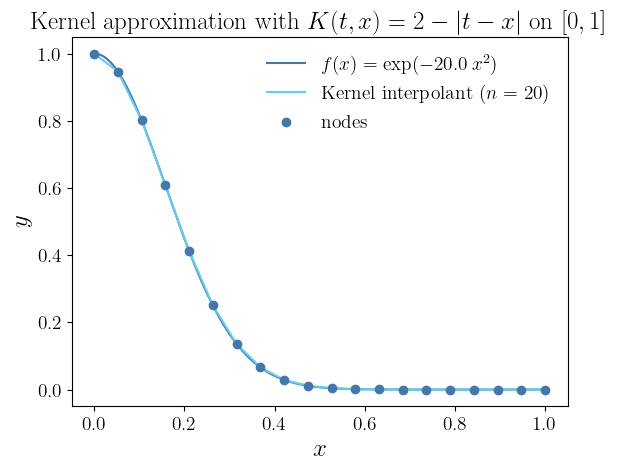

||error||_inf = 0.013183940208270073
||error||_2   = 0.0032593328315442633


In [7]:
# Target function, you may change this as you wish
a=20.
def f_exp_sq(x, a=a):
    x = np.asarray(x)
    return np.exp(-a * x**2)
f_exp_sq.label=rf"$f(x)=\exp(-{a}\,x^2)$"

K = K_abs          # swap to K_abs_exp, etc.
f = f_exp_sq             # swap to f2, etc.

n = 20
x_nodes = np.linspace(0.0, 1.0, n)
a, f_hat, G, y = kernel_interpolant(K, x_nodes, f)

x_grid = np.linspace(0.0, 1.0, 600)

plt.figure()
plt.plot(x_grid, f(x_grid), label=getattr(f, "label", "f"))
plt.plot(x_grid, f_hat(x_grid), label=rf"Kernel interpolant ($n={n}$)")
plt.scatter(x_nodes, y, marker="o", label="nodes", zorder=3)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(rf"Kernel approximation with {getattr(K, 'label', 'K')} on $[0,1]$")
plt.legend()
plt.show()

err_inf = np.max(np.abs(f_hat(x_grid) - f(x_grid)))
err_l2 = np.sqrt(np.trapezoid((f_hat(x_grid) - f(x_grid))**2, x_grid))
print("||error||_inf =", err_inf)
print("||error||_2   =", err_l2)
